# Heatmap of Maximum Foot Pressure Data During Running
## Background
As part of my master’s thesis, I created heatmaps of the average maximum pressure values of the foot during running across multiple subjects at the same speed and wearing the same shoes. In this notebook, I demonstrate how I created these heatmaps using one of the speed/shoe combinations. For those interested in the details of the data acquisition, I’ll briefly go over the measurement setup used, excerpting a minor section of my thesis.
<br>
<br>
"The force and pressure data for each step were collected using the FDM-THQ 3i pressure distribution measurement system (Zebris medical GmbH, Isny, Germany). It consists of a pressure sensor mat covering an area of 135.5 x 54.1 cm that is integrated into a quasar® lt treadmill (h/p/cosmos sports and medical GmbH, Nussdorf-Traunstein, Germany) with a running surface of 170 x 65 cm, and the associated Zebris FDM v1.18.48 software, also by Zebris.
<br>
The mat consists of a matrix of 10,240 high-quality capacitive pressure sensors arranged in closely spaced columns and rows, providing a resolution of 1.4 sensors/cm². The sensors operate within a calibrated measurement range of 1-120 N/cm² with an accuracy of ±5% within this range. Once a pressure threshold of 1 N/cm² is exceeded, the sensors start to record a step and cease recording when the pressure falls below this threshold. Data were recorded at a frequency of 300 Hz (Zebris Medical GmbH, 2019).
<br>
<br>
Data acquisition was managed through the Zebris software, which also automatically created a matrix of pressure values across the foot and stored them in a CSV file for each trial.

## Data Loading and Exploration

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from scipy.interpolate import RegularGridInterpolator
import glob
import csv

In [2]:
# define file path
base_path = '../data/*/pressure-plots_stance_maximum-R.csv'

There are two minor issues with the data:
1. The structure of the initial rows within each CSV file differs from the rest of the file, making it impossible to use the head() function, as this function isn't robust enough to handle the empty cells created by the inconsistent structure within each file. This complicates the process of gathering information on how to manipulate each DataFrame in order to get a usable matrix.
2. Depending on the recording date, different versions of the recording software were used. Consequently, the CSV file separator can be either ";" or "\t".

In [3]:
# get the list of CSV files matching the path
csv_files = glob.glob(base_path)


# inspect the first few lines of the first file to understand its structure
with open(csv_files[0], 'r') as file:
    for i in range(6):
        print(file.readline())

ï»¿type	name	time_units	begin_time	frequency	count	units	cell_count_x	cell_count_y	cell_size_mm_x	cell_size_mm_y

signal_matrix	"R Maximaldruckbilder, Stand, Maximum"	"s"	0.000	1	1	"N/cmÂ²"	18	40	8.469	8.469



time	x1	x2	x3	x4	x5	x6	x7	x8	x9	x10	x11	x12	x13	x14	x15	x16	x17	x18

0.000	0.000	0.000	0.000	0.000	0.001	0.004	0.005	0.006	0.009	0.014	0.008	0.001	0.000	0.000	0.000	0.000	0.000	0.000

	0.000	0.000	0.005	0.138	0.546	1.128	1.298	1.375	1.188	1.415	1.034	0.290	0.039	0.000	0.000	0.000	0.000	0.000



This output shows that the first three rows are either different in structure or empty and can therefore be removed, leaving the fourth row to serve as column headers. Additionally, with the initial rows removed, the first column contains only one value that does not belong to the overall matrix and can therefore be removed. Let’s see how the header of the matrix looks now with the first three rows skipped and the first column removed.

In [4]:
# skipping the first three rows and dropping the first column of the test dataframe
df = pd.read_csv(csv_files[0], sep='\t', skiprows=3) 
df.drop(df.columns[0], axis=1, inplace=True)
print(df.head())

    x1     x2     x3     x4      x5      x6      x7      x8      x9     x10  \
0  0.0  0.000  0.000  0.000   0.001   0.004   0.005   0.006   0.009   0.014   
1  0.0  0.000  0.005  0.138   0.546   1.128   1.298   1.375   1.188   1.415   
2  0.0  0.004  0.319  1.678   3.646   4.410   4.317   4.716   4.111   3.724   
3  0.0  0.102  1.457  4.921   8.190   9.209   8.110   7.983   7.935   6.118   
4  0.0  0.462  3.679  8.935  12.930  13.692  11.763  12.164  13.094  11.134   

     x11    x12    x13    x14    x15   x16  x17  x18  
0  0.008  0.001  0.000  0.000  0.000  0.00  0.0  0.0  
1  1.034  0.290  0.039  0.000  0.000  0.00  0.0  0.0  
2  3.346  1.884  0.459  0.002  0.000  0.00  0.0  0.0  
3  5.124  4.270  1.779  0.299  0.025  0.00  0.0  0.0  
4  7.352  5.946  4.440  2.483  0.576  0.02  0.0  0.0  


## Data Cleaning and Transformation
The idea for this section is to store all the matrices in a list and then create a mean of those matrices, which can then be visualized. To achieve a clear picture, a new size for the graphic must be defined. Additionally, a function is created that can detect the separator for each CSV file.

In [5]:
# create a list to store all dataframes in
dfs = []

# define the new size of the matrix (original size is 40x18)
new_size = (336, 144)

# create function to detect the delimiter/seperator for each CSV file
def detect_delimiter(file_path):
    with open(file_path, 'r') as f:
        first_line = f.readline()
        sniffer = csv.Sniffer()
        delimiter = sniffer.sniff(first_line).delimiter
    return delimiter

Next, the code iterates over each file in a for loop, detecting its individual separator, removing unnecessary rows and columns, and interpolating all the matrices to the new size before storing them in the list.

In [6]:
# iterating over all fitting csv files in the chosen path
for file in glob.glob(base_path):
    # detect the delimiter
    sep = detect_delimiter(file)

    # load csv file as dataframe, skip first three rows and drop first column
    df = pd.read_csv(file, skiprows=3, sep=sep)
    df = df.drop(df.columns[0], axis=1) 

    # add row of zeros at the top, bottom and left of the matrix as it will be displayed as white and widen to the border of the heatmap
    df = pd.concat([pd.DataFrame(np.zeros((1, df.shape[1])), columns=df.columns), df], ignore_index=True)
    df.insert(0, 'zero_col', 0)
    df.loc[df.shape[0]] = 0

    # interpolate to the new size
    x = np.arange(0, df.shape[1])
    y = np.arange(0, df.shape[0])
    interpolating_function = RegularGridInterpolator((y, x), df.values, method='cubic')
    x_new = np.linspace(0, df.shape[1]-1, new_size[1])
    y_new = np.linspace(0, df.shape[0]-1, new_size[0])
    xx, yy = np.meshgrid(x_new, y_new)
    df_new = interpolating_function((yy, xx))

    # append interpolated dataframe to the list
    dfs.append(df_new)

As a last step, the list of interpolated dataframes is converted into a 3D numpy array. Then, the mean of all matrices is calculated to create a single matrix that can be visualized.

In [7]:
# convert list of interpolated dataframes to a 3D numpy array
data = np.array(dfs)

# generate the mean of all matrices
mean_matrix = data.mean(axis=0)

## Data Visualization

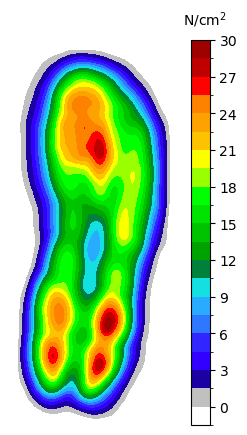

In [8]:
# define custom color ranges based on the color codes the zebris application is using
cmap_colors = [(0.0, 'white'), (0.45, '#c0c0c0'), (1.5, '#1c00a3'), (3.0, '#3200ff'), (4.5, '#3126ff'), (6.0, '#2e78ff'),
                (7.5, '#29acff'), (9.0, '#13e0e0'), (10.5, '#00813b'), (12.0, '#00a200'), (13.5, '#00c300'),
                (15.0, '#00e300'), (16.5, '#00ff00'), (18.0, '#9aff00'), (19.5, '#fbff00'), (21.0, '#fdc300'),
                (22.5, '#fda200'), (24.0, '#fd8200'), (25.5, '#fe0100'),(27.0, '#bf0000'), (28.5, '#9f0000'), (30.0, '#9f0000')]

# create a ListedColormap object using the defined colors
cmap = ListedColormap([color for value, color in cmap_colors])
bounds = [color_value for color_value, color in cmap_colors]

# create a color map with the mean matrix
fig, ax = plt.subplots(figsize=(4, 5))
im = ax.imshow(mean_matrix, cmap=cmap, norm=matplotlib.colors.BoundaryNorm(bounds, cmap.N))
cbar = ax.figure.colorbar(im, ax=ax, format=matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
cbar.set_ticks([0.45, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30])

# set the colorbar label and rotate it horizontally
cbar.ax.set_xlabel('N/cm$^2$', rotation=0)
cbar.ax.xaxis.set_label_coords(0.75, 1.08)

# turn off the axis and frame for a cleaner look
ax.set_axis_off()
ax.set_frame_on(False)

# display the plot
plt.show()